In [ ]:
!pip install keras==2.2.3

In [ ]:
!pip install tensorflow-gpu==1.15

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [ ]:
import keras
keras.__version__

In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
from google.colab import drive
drive.mount("/mntDrive")

Mounted at /mntDrive


In [ ]:
drive.flush_and_unmount()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

import os

In [ ]:
print(tf.__version__)

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
def base_model():

    base_model = MobileNet(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # for layer in base_model.layers:
    #   layer.trainable = False

    return base_model

def vmmr_net(feature_extractor, num_classes):
    x = feature_extractor.output
    x = layers.DepthwiseConv2D((3, 3), strides=(2, 2), padding="same", depthwise_regularizer=tf.keras.regularizers.l2(0.01), name="cls_dw_conv_1")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(name="cls_relu_1")(x)
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01), name="cls_conv_1")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(name="cls_relu_2")(x)
    x = layers.DepthwiseConv2D((3, 3), strides=(2, 2), padding="same", depthwise_regularizer=tf.keras.regularizers.l2(0.01), name="cls_dw_conv_2")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(name="cls_relu_3")(x)
    x = layers.Conv2D(128, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01), name="cls_conv_2")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(name="cls_relu_4")(x)
    x = layers.AveragePooling2D((2, 2), strides=(1, 1), name="avg_pool")(x)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(num_classes, activation="softmax", name="cls_fc")(x)

    return x

def vmmr_net_2(feature_extractor, num_classes):
  x = feature_extractor.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Reshape((1, 1, 1024))(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Conv2D(num_classes, (1, 1), kernel_regularizer=tf.keras.regularizers.l2(0.01), padding="same")(x)
  x = layers.Reshape((num_classes,))(x)
  x = layers.Activation(activation="softmax")(x)

  return x

def vgg_vmmr_net(num_classes):
  pass


def vgg_based_mini_vmmr_net(num_classes):
  x_in = layers.Input(shape=(224, 224, 3))

  x = layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu")(x_in)
  x = layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu")(x)
  x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

  x = layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu")(x)
  x = layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu")(x)
  x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

  x = layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu")(x)
  x = layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu")(x)
  x = layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu")(x)
  x = layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu")(x)
  x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

  x = layers.DepthwiseConv2D((3, 3), strides=(2, 2), padding="same", activation="relu", depthwise_regularizer=tf.keras.regularizers.l2(0.001), name="cls_dw_conv_1")(x)
  x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001), name="cls_conv_1")(x)
  x = layers.BatchNormalization()(x)
  x = layers.DepthwiseConv2D((3, 3), strides=(2, 2), padding="same", activation="relu", depthwise_regularizer=tf.keras.regularizers.l2(0.001), name="cls_dw_conv_2")(x)
  x = layers.Conv2D(512, (3, 3), padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001), name="cls_conv_2")(x)
  x = layers.BatchNormalization()(x)
  x = layers.AveragePooling2D((2, 2), strides=(1, 1), name="avg_pool")(x)
  x = layers.Flatten(name='flatten')(x)
  x = layers.Dense(num_classes, activation="softmax", name="cls_fc")(x)

  model = Model(x_in, x)

  return model

def squeeze_net(nb_classes):

    l2_coeff = 0.001

    input_img = layers.Input(shape=(224, 224, 3))
    conv1 = layers.Conv2D(96, kernel_size=(7, 7), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), strides=(2, 2), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='conv1')(input_img)
    maxpool1 = layers.MaxPooling2D( pool_size=(3, 3), strides=(2, 2), name='maxpool1')(conv1)

    fire2_squeeze = layers.Conv2D(16, kernel_size=(1, 1), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire2_squeeze')(maxpool1)
    fire2_expand1 = layers.Conv2D(64, kernel_size=(1, 1), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire2_expand1')(fire2_squeeze)
    fire2_expand2 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire2_expand2')(fire2_squeeze)
    merge2 = layers.concatenate([fire2_expand1, fire2_expand2])

    fire3_squeeze = layers.Conv2D(16, kernel_size=(1, 1), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire3_squeeze')(merge2)
    fire3_expand1 = layers.Conv2D(64, kernel_size=(1, 1), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire3_expand1')(fire3_squeeze)
    fire3_expand2 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire3_expand2')(fire3_squeeze)
    merge3 = layers.concatenate([fire3_expand1, fire3_expand2])

    fire4_squeeze = layers.Conv2D(32, kernel_size=(1, 1), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire4_squeeze')(merge3)
    fire4_expand1 = layers.Conv2D(128, kernel_size=(1, 1), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire4_expand1')(fire4_squeeze)
    fire4_expand2 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire4_expand2')(fire4_squeeze)
    merge4 = layers.concatenate([fire4_expand1, fire4_expand2])
    maxpool4 = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool4')(merge4)

    fire5_squeeze = layers.Conv2D(32, kernel_size=(1, 1), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire5_squeeze')(maxpool4)
    fire5_expand1 = layers.Conv2D(128, kernel_size=(1, 1), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire5_expand1')(fire5_squeeze)
    fire5_expand2 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire5_expand2')(fire5_squeeze)
    merge5 = layers.concatenate([fire5_expand1, fire5_expand2])

    fire6_squeeze = layers.Conv2D(48, kernel_size=(1, 1), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire6_squeeze')(merge5)
    fire6_expand1 = layers.Conv2D(192, kernel_size=(1, 1), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire6_expand1')(fire6_squeeze)
    fire6_expand2 = layers.Conv2D(192, kernel_size=(3, 3), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire6_expand2')(fire6_squeeze)
    merge6 = layers.concatenate([fire6_expand1, fire6_expand2])

    fire7_squeeze = layers.Conv2D(48, kernel_size=(1, 1), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire7_squeeze')(merge6)
    fire7_expand1 = layers.Conv2D(192, kernel_size=(1, 1), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire7_expand1')(fire7_squeeze)
    fire7_expand2 = layers.Conv2D(192, kernel_size=(3, 3), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire7_expand2')(fire7_squeeze)
    merge7 = layers.concatenate([fire7_expand1, fire7_expand2])

    fire8_squeeze = layers.Conv2D(64, kernel_size=(1, 1), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire8_squeeze')(merge7)
    fire8_expand1 = layers.Conv2D(256, kernel_size=(1, 1), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire8_expand1')(fire8_squeeze)
    fire8_expand2 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire8_expand2')(fire8_squeeze)
    merge8 = layers.concatenate([fire8_expand1, fire8_expand2])

    maxpool8 = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool8')(merge8)

    fire9_squeeze = layers.Conv2D(64, kernel_size=(1, 1), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire9_squeeze')(maxpool8)
    fire9_expand1 = layers.Conv2D(256, kernel_size=(1, 1), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire9_expand1')(fire9_squeeze)
    fire9_expand2 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='same', name='fire9_expand2')(fire9_squeeze)
    merge9 = layers.concatenate([fire9_expand1, fire9_expand2])

    fire9_dropout = layers.Dropout(0.5, name='fire9_dropout')(merge9)
    conv10 = layers.Conv2D(nb_classes, kernel_size=(1, 1), kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l2_coeff), padding='valid', name='conv10')(fire9_dropout)
    # The size should match the output of conv10
    avgpool10 = layers.GlobalAveragePooling2D(name='global_avgpool10')(conv10)

    flatten = layers.Flatten(name='flatten')(avgpool10)
    softmax = layers.Activation("softmax", name='softmax')(flatten)

    return Model(input_img, softmax)

In [ ]:
mobilenet = MobileNet(weights="imagenet", input_shape=(224, 224, 3))
mobilenet.summary(line_length=150)

In [ ]:
import os
import glob
import numpy as np
import cv2
import tensorflow as tf

def resize_to_square(img, new_size):
  height, width = img.shape[:2]
  target_height, target_width = new_size

  if height > target_height or width > target_width: # shrinking image
      interp = cv2.INTER_AREA
  else: # stretching image
      interp = cv2.INTER_CUBIC
  
  aspect_ratio = width / height

  if aspect_ratio > 1:
    new_width = target_width
    new_height = np.round(new_width / aspect_ratio).astype(int)
    pad_vertical = (target_height - new_height)/2
    pad_top, pad_bot = np.floor(pad_vertical).astype(int), np.ceil(pad_vertical).astype(int)
    pad_left, pad_right = 0, 0
  elif aspect_ratio < 1:
    new_height = target_height
    new_width = np.round(new_height * aspect_ratio).astype(int)
    pad_horizontal = (target_width - new_width)/2
    pad_left, pad_right = np.floor(pad_horizontal).astype(int), np.ceil(pad_horizontal).astype(int)
    pad_top, pad_bot = 0, 0
  else:
    new_height, new_width = target_height, target_width
    pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

  color = [0, 0, 0]

  scaled_img = cv2.resize(img, (new_width, new_height), interpolation=interp)
  scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=color)

  return scaled_img

def load_ssd_extractor():
  import os
  import cv2
  import numpy as np

  %cd /mntDrive/My\ Drive/CarDetection/models/research/

  from object_detection.utils import label_map_util
  import tensorflow as tf

  base_path = "/mntDrive/My Drive/CarDetection/"
  model_name = base_path + "/training/ssd_mobilenet/"
  path_to_graph = model_name + "/frozen_inference_graph.pb"
  path_to_labels = base_path + "models/research/object_detection/data/mscoco_label_map.pbtxt"
  num_classes = 1

  category_index = label_map_util.create_category_index_from_labelmap(path_to_labels, use_display_name=True)

  detection_graph = tf.Graph()
  with detection_graph.as_default():
    graph_def = tf.GraphDef()
    with tf.gfile.GFile(path_to_graph, "rb") as fid:
      serialized_graph = fid.read()
      graph_def.ParseFromString(serialized_graph)
      tf.import_graph_def(graph_def)

  %cd /content

  return detection_graph, category_index

In [ ]:
#Area extractor using SSD for detecting cars in samples
import os
import cv2

def ssd_area_extractor(data_folder, dest_data_folder):

  labels = os.listdir(data_folder)
  
  detection_graph, category_index = load_area_extractor()

  with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:

      image_tensor = detection_graph.get_tensor_by_name("import/image_tensor:0")
      boxes_tensor = detection_graph.get_tensor_by_name("import/detection_boxes:0")
      scores_tensor = detection_graph.get_tensor_by_name("import/detection_scores:0")
      classes_tensor = detection_graph.get_tensor_by_name("import/detection_classes:0")
      num_detections_tensor = detection_graph.get_tensor_by_name("import/num_detections:0")
      
      for label_folder in labels:
        label_path = os.path.join(data_folder, label_folder)
        print(label_path)
        dest_folder = os.path.join(dest_data_folder, label_folder)
        print(dest_folder)
        
        if not os.path.exists(dest_folder):
          os.makedirs(dest_folder)

        for img_file in os.listdir(label_path):
          img_path = os.path.join(label_path, img_file)

          img = cv2.imread(img_path)
          img = img.astype(np.float32)
          img_np_exp = np.expand_dims(img, axis=0)
          
          (boxes, scores, classes, num_detections) = sess.run([boxes_tensor, scores_tensor, classes_tensor, num_detections_tensor], feed_dict={image_tensor: img_np_exp})

          boxes = np.squeeze(boxes)
          classes = np.squeeze(classes).astype(np.int32)
          scores = np.squeeze(scores)

          score_filter = np.where(scores > 0.5)
          boxes = boxes[score_filter]
          scores = scores[score_filter]
          classes = classes[score_filter]
          
          try:
            if len(boxes) > 1:
              max_area = np.NINF
              for idx in range(boxes.shape[0]):

                im_height, im_width, _ = img.shape
                ymin, xmin, ymax, xmax = tuple(boxes[idx].tolist())
                xmin = int(xmin * im_width)
                xmax = int(xmax * im_width)
                ymin = int(ymin * im_height)
                ymax = int(ymax * im_height)
                
                area = (ymax - ymin) * (xmax - xmin)
                
                if area > max_area:
                  max_area = area
                  bbox = (ymin, ymax, xmin, xmax)         
            else:

                im_height, im_width, _ = img.shape
                ymin, xmin, ymax, xmax = tuple(boxes[0].tolist())
                xmin = int(xmin * im_width)
                xmax = int(xmax * im_width)
                ymin = int(ymin * im_height)
                ymax = int(ymax * im_height)

                bbox = (ymin, ymax, xmin, xmax)
                  
            data = img[bbox[0]:bbox[1], bbox[2]:bbox[3]]

          except:
            data = img

          dest = os.path.join(dest_folder, img_file)
          print(dest)
          cv2.imwrite(dest, data)

In [ ]:
ssd_area_extractor("/mntDrive/My Drive/Dataset/car_dataset_test", "/mntDrive/My Drive/Dataset/car_dataset_test") 

In [ ]:
#Custom data generator
import os
import cv2
import numpy as np
from keras.utils import to_categorical

def generate_label_mapping(data_folder):
  label_mapping = {}

  labels = list(sorted(os.listdir(data_folder)))

  for idx, label in enumerate(labels):
    label_mapping[label] = idx

  # label_mapping = dict(sorted(label_mapping.items()))
  print(label_mapping)

  return label_mapping

def data_generator(data_folder, label_mapping, weights_dict, rescale=1./255, target_size=(224, 224), batch_size=32, mode="train"):
  from random import shuffle, random, sample, uniform

  augmentation_ops = ["horizontal_flip", "vertical_flip", "rotation", "channel_shift", "horizontal_shift", "vertical_shift"]

  def rotate_img(img, angle=45):
    angle = int(uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))

    return img

  def channel_shift(img, value=50):
    value = int(uniform(-value, value))
    img += value
    img[:, :, :][img[:, :, :] > 255] = 255
    img[:, :, :][img[:, :, :] < 0] = 0
    img = img.astype(np.float32)

    return img

  def horizontal_shift(img, ratio):
    ratio = uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = w*ratio
    if ratio > 0:
        img = img[:, :int(w-to_shift), :]
    if ratio < 0:
        img = img[:, int(-1*to_shift):, :]

    return img

  def vertical_shift(img, ratio):
    ratio = uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = h*ratio
    if ratio > 0:
        img = img[:int(h-to_shift), :, :]
    if ratio < 0:
        img = img[int(-1*to_shift):, :, :]

    return img

  all_imgs = []
  for folder in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, folder)
    for f in os.listdir(folder_path):
      if f.endswith(".jpg") or f.endswith(".png") or f.endswith(".jpeg"):
        all_imgs.append(os.path.join(folder_path, f))
  
  shuffle(all_imgs)

  start = 0
  end = batch_size
  
  while True:
    
    if start == 0:
      shuffle(all_imgs)

    batch_files = all_imgs[start:end]

    batch_data = []
    batch_labels = []
    sample_weights = []
    
    i = 0
    for f in batch_files:

      label = f.split("/")[-2]

      img = cv2.imread(f)
      img = img.astype(np.float32)

      if mode == "train" and random() > 0.5:
        # do the augmentations here
        aug_op = sample(augmentation_ops, 1)[0]
        # print(i, label, aug_op)
        if aug_op == "horizontal_flip":
          img = cv2.flip(img, 1)
        elif aug_op == "vertical_flip":
          img = cv2.flip(img, 0)
        elif aug_op == "rotation":
          img = rotate_img(img)
        elif aug_op == "channel_shift":
          img = channel_shift(img)
        elif aug_op == "horizontal_shift":
          img = horizontal_shift(img, 0.7)
        elif aug_op == "vertical_shift":
          img = vertical_shift(img, 0.5)
          
      # img = resize_to_square(img, target_size)
      img = cv2.resize(img, target_size)
      # img *= rescale

      # img = cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)

      # cv2.imwrite(f"./train_imgs/{i}_{label}.jpg", img)
      # i += 1
      batch_data.append(img)
      sample_weights.append(weights_dict[label_mapping[label]])
      categorical_label = to_categorical(label_mapping[label], len(label_mapping))
      batch_labels.append(categorical_label)


    data = np.array(batch_data)
    labels = np.array(batch_labels)
    weights = np.array(sample_weights)
    # data = data.astype('float32')
    # labels = labels.astype('float32')
    yield (data, labels, weights)

    start += batch_size
    end += batch_size

    if end >= len(all_imgs):
      start = 0
      end = batch_size

Using TensorFlow backend.


In [ ]:
!rm -rf train_imgs
!mkdir train_imgs

In [ ]:
label_map = generate_label_mapping("/mntDrive/My Drive/Dataset/car_dataset_extracted")
# data_generator("/mntDrive/My Drive/Dataset/car_dataset_extracted", label_map)

In [ ]:
def create_class_weights(class_indices, data_path):
  import os
  import math
  import numpy as np

  inv_indices = {v: k for k, v in class_indices.items()}

  label_count = {}
  for label in inv_indices.keys():
    label_path = os.path.join(data_path, inv_indices[label])
    label_count[label] = len(os.listdir(label_path))

  max_count = float(max(label_count.values()))  
  total_count = sum(label_count.values())

  class_weights = {}
  for key in label_count.keys():
    weight = max_count / float(label_count[key])
    class_weights[key] = round(weight, 2)

  print(class_weights)

  return class_weights, total_count

In [ ]:
def data_for_training(data_path="/mntDrive/My Drive/Dataset/car_dataset_extracted"):
  
  data_gen = image.ImageDataGenerator(rescale=1./255, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True, validation_split=0.2, preprocessing_function=preprocess_input)
  
  # data_gen = image.ImageDataGenerator(rescale=1./255, validation_split=0.2, horizontal_flip=True, vertical_flip=True, preprocessing_function=preprocess_input)

  train_generator = data_gen.flow_from_directory(data_path, target_size=(224,224), class_mode="categorical", batch_size=32, subset="training")

  validation_generator = data_gen.flow_from_directory(data_path, target_size=(224,224), class_mode="categorical", batch_size=32, subset="validation")

  return train_generator, validation_generator

In [ ]:
train_gen, validation_gen = data_for_training(data_path="/mntDrive/My Drive/Dataset/car_dataset_extracted")

label_map = train_gen.class_indices
print(f"Class indices:{label_map}")

class_weights, _ = create_class_weights(label_map, "/mntDrive/My Drive/Dataset/car_dataset_extracted")

In [ ]:
import pandas as pd

epochs = 50
epoch_length = 500
validation_length = 250
checkpoint_path = "/mntDrive/My Drive/Models/vmmr_net_4.h5"
history_output_path = "/mntDrive/My Drive/TrainingHistory/vmmr_net_4"

data_path = "/mntDrive/My Drive/Dataset/car_dataset_extracted"
val_path = "/mntDrive/My Drive/Dataset/car_dataset_validation"

label_map = generate_label_mapping(data_path)
weights, _ = create_class_weights(label_map, data_path)
train_gen = data_generator(data_path, label_map, weights)
validation_gen = data_generator(val_path, label_map, weights, mode="val")
num_classes = len(label_map)

feature_extractor = base_model()

feature_extractor.summary()

# vmmr_cls = vmmr_net(feature_extractor, num_classes=num_classes)
vmmr_cls = vmmr_net_2(feature_extractor, num_classes=num_classes)

if not os.path.exists(history_output_path):
  os.makedirs(history_output_path)

checkpoint_callback = ModelCheckpoint(checkpoint_path, monitor="val_loss", verbose=1)
early_stopper = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

try:
  vmmr_cls_model = load_model(checkpoint_path)
  print("Defrosting layers")
  for layer in vmmr_cls_model.layers:
    layer.trainable = True

  print("Loading existing model.")
  learning_rate = 0.0001
  optimizer = Adam(lr=learning_rate)

  vmmr_cls_model.compile(optimizer=optimizer, metrics=["categorical_accuracy", tf.keras.metrics.AUC()], loss="categorical_crossentropy")
except:
  vmmr_cls_model = Model(feature_extractor.inputs, vmmr_cls)
  print("Creating model.")
  learning_rate = 0.001
  optimizer = Adam(lr=learning_rate)

  vmmr_cls_model.compile(optimizer=optimizer, metrics=["categorical_accuracy", tf.keras.metrics.AUC()], loss="categorical_crossentropy") 

vmmr_cls_model.summary()

In [ ]:
# mini-VGG
epochs = 50
epoch_length = 500
validation_length = 250
checkpoint_path = "/mntDrive/My Drive/Models/vmmr_net_vgg.h5"
history_output_path = "/mntDrive/My Drive/TrainingHistory/vmmr_net_vgg"

if not os.path.exists(history_output_path):
  os.makedirs(history_output_path)

data_path = "/mntDrive/My Drive/Dataset/car_dataset_extracted"
val_path = "/mntDrive/My Drive/Dataset/car_dataset_validation"

label_map = generate_label_mapping(data_path)
weights = create_class_weights(label_map, data_path)
train_generator = data_generator(data_path, label_map)
validation_generator = data_generator(val_path, label_map)

num_classes = len(label_map)

checkpoint_callback = ModelCheckpoint(checkpoint_path, monitor="val_loss", verbose=1)
early_stopper = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

try:
  vmmr_cls_model = load_model(checkpoint_path)
  print("Loading existing model.")
  learning_rate = 5e-4
  optimizer = Adam(lr=learning_rate)

  vmmr_cls_model.compile(optimizer=optimizer, metrics=["categorical_accuracy", tf.keras.metrics.AUC()], loss="categorical_crossentropy")
except:
  vmmr_cls_model = vgg_based_mini_vmmr_net(num_classes)
  print("Creating mini-VGG model.")
  learning_rate = 1e-3
  optimizer = Adam(lr=learning_rate)

  vmmr_cls_model.compile(optimizer=optimizer, metrics=["categorical_accuracy", tf.keras.metrics.AUC()], loss="categorical_crossentropy")

vmmr_cls_model.summary()

In [ ]:
K.clear_session()

In [ ]:
# Squeeze Net
checkpoint_path = "/mntDrive/My Drive/Models/squeeze_net.h5"
history_output_path = "/mntDrive/My Drive/TrainingHistory/squeeze_net"

data_path = "/mntDrive/My Drive/Dataset/car_dataset_extracted"
val_path = "/mntDrive/My Drive/Dataset/car_dataset_validation"

label_map = generate_label_mapping(data_path)
weights, total_count = create_class_weights(label_map, data_path)

epochs = 100
batch_size = 64
epoch_length = 500
validation_length = 250

train_gen = data_generator(data_path, label_map, weights, batch_size=batch_size)
validation_gen = data_generator(val_path, label_map, weights, batch_size=batch_size, mode="val")

num_classes = len(label_map)

if not os.path.exists(history_output_path):
  os.makedirs(history_output_path)

from keras import backend as K

checkpoint_callback = ModelCheckpoint(checkpoint_path, monitor="val_loss", verbose=1)
# early_stopper = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

try:
  vmmr_cls_model = load_model(checkpoint_path)
  print("Defrosting layers")
  for layer in vmmr_cls_model.layers:
    layer.trainable = True

  print("Loading existing model.")
  learning_rate = 1e-4
  optimizer = Adam(lr=learning_rate)

  vmmr_cls_model.compile(optimizer=optimizer, metrics=["accuracy", tf.keras.metrics.AUC()], loss="categorical_crossentropy")
except:
  vmmr_cls_model = vmmr_cls = squeeze_net(num_classes)

  print("Creating model.")
  learning_rate = 1e-3
  optimizer = Adam(lr=learning_rate)

  vmmr_cls_model.compile(optimizer=optimizer, metrics=["accuracy", tf.keras.metrics.AUC()], loss="categorical_crossentropy") 

vmmr_cls_model.summary()

In [ ]:
from keras import backend as K
from keras.callbacks import CSVLogger

# K.tensorflow_backend._get_available_gpus()
# config = tf.ConfigProto(device_count = {'GPU': 1}, log_device_placement=True) 
# sess = tf.Session(config=config, graph=vmmr_cls_model.output.graph)
# sess.run(tf.global_variables_initializer())
# K.set_session(sess)

vmmr_cls_model.summary()

csv_logger = CSVLogger(f"{history_output_path}/vmmr_net_history.csv", append=True)

vmmr_cls_model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=epoch_length, 
                            callbacks=[checkpoint_callback, csv_logger], class_weight=None,
                             validation_steps=validation_length, validation_data=validation_gen)

vmmr_cls_model.save(checkpoint_path)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [ ]:
vmmr_model = load_model("/mntDrive/My Drive/Models/vmmr_net_4.h5")
vmmr_model.summary()

In [ ]:
!rm -rf vmmr

In [ ]:
from tensorflow.keras.preprocessing import image

# sanity_gen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
# generator = sanity_gen.flow_from_directory("/mntDrive/My Drive/Dataset/car_dataset_test/", target_size=(224,224), class_mode="categorical", batch_size=32)
label_map = generate_label_mapping("/mntDrive/My Drive/Dataset/car_dataset_test/")
# print(label_map)
weights, _ = create_class_weights(label_map, "/mntDrive/My Drive/Dataset/car_dataset_test/")
sanity_gen = data_generator("/mntDrive/My Drive/Dataset/car_dataset_test/", label_map, weights, mode="val")
eval_result = vmmr_model.evaluate_generator(sanity_gen, steps=50)
result_dict = {vmmr_model.metrics_names[0]: eval_result[0], vmmr_model.metrics_names[1]: eval_result[1], vmmr_model.metrics_names[2]: eval_result[2]}
# result_dict = {vmmr_model.metrics_names[0]: eval_result[0], vmmr_model.metrics_names[1]: eval_result[1]}
print(result_dict)

{'audi a3': 0, 'audi a4': 1, 'audi q7': 2, 'bmw 1 series': 3, 'nissan micra': 4, 'opel astra': 5, 'renault captur': 6, 'renault clio': 7, 'renault megane': 8, 'volkswagen golf': 9, 'volkswagen passat': 10, 'volkswagen polo': 11}
{0: 1.67, 1: 1.41, 2: 1.88, 3: 1.55, 4: 1.22, 5: 1.04, 6: 1.1, 7: 1.44, 8: 1.0, 9: 1.47, 10: 1.59, 11: 1.42}
{'loss': 0.22839161220937967, 'categorical_accuracy': 0.95375, 'auc_1': 0.9935778}


In [ ]:
import cv2
import numpy as np

sanity_path = "/mntDrive/My Drive/Dataset/car_dataset_test/"

results = {}

indices = {'audi a3': 0, 'audi a4': 1, 'audi q7': 2, 'bmw 1 series': 3, 'nissan micra': 4, 'opel astra': 5, 'renault captur': 6, 
           'renault clio': 7, 'renault megane': 8, 'volkswagen golf': 9, 'volkswagen passat': 10, 'volkswagen polo': 11}

inv_indices = {v: k for k, v in indices.items()}

for folder in os.listdir(sanity_path):
  results[folder] = {}
  img_path = os.path.join(sanity_path, folder)
  for img in os.listdir(img_path):
    p = os.path.join(img_path, img)

    img_data = cv2.imread(p)
    img_data = img_data.astype(np.float32)
    # img_data = resize_to_square(img_data, (224, 224))
    img_data = cv2.resize(img_data, (224, 224))
    # img_data /= 255.0
    # img_data = cv2.normalize(img_data, img_data, 0, 255, cv2.NORM_MINMAX)
    img_data = np.expand_dims(img_data, axis=0)

    pred = vmmr_model.predict(img_data)
    pred = np.squeeze(pred)
    cls = inv_indices[np.argmax(pred)]
    score = pred[np.argmax(pred)]

    results[folder][img] = (cls, score) 

results

7459


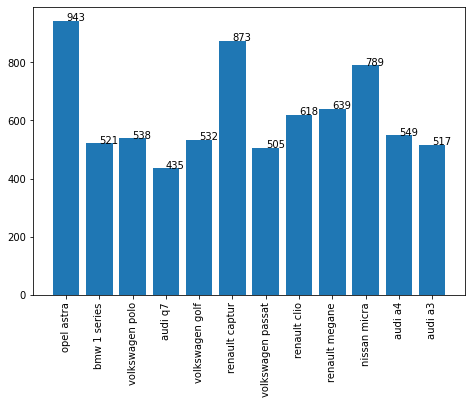

In [ ]:
import matplotlib.pyplot as plt
import os

data_folder = "/mntDrive/My Drive/Dataset/car_dataset_extracted/"

counts = {}

for folder in os.listdir(data_folder):
  path = os.path.join(data_folder, folder)
  counts[folder] = len(os.listdir(path))

i = 0
for c in counts:
  i += counts[c]

print(i)

# for k, v in counts.items():
#   counts[k] = float('%.3f' % (v / i)) 

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = [k for k, v in counts.items()]
values = [v for k, v in counts.items()]
ax.bar(labels,values)
plt.xticks(rotation=90)
for i, v in enumerate(values):
  plt.text(labels[i], v + 0.01, str(v))
plt.show()

In [ ]:
import tensorflow as tf
interpreter = tf.lite.Interpreter("/mntDrive/My Drive/Models/vmmr_net_2.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

In [ ]:
!rm -rf /content/vmmr

In [ ]:
#Split validation data

import shutil
import os
import random
import sys

source_path = "/mntDrive/My Drive/Dataset/car_dataset_extracted/"
dest_path = "/mntDrive/My Drive/Dataset/car_dataset_validation/"
# dest_path = "/mntDrive/My Drive/Dataset/car_dataset_test/"

# dest_path = "/mntDrive/My Drive/Dataset/car_dataset_extracted/"
# source_path = "/mntDrive/My Drive/Dataset/car_dataset_validation/"

val_split = 0.1

for folder in os.listdir(source_path):
  folder_path = os.path.join(source_path, folder)
  samples = os.listdir(folder_path)
  sample_size = len(samples)

  validation_data = random.sample(samples, int(sample_size * val_split))
  # print(validation_data)
  
  val_path = os.path.join(dest_path, folder)
  if not os.path.exists(val_path):
    os.makedirs(val_path)
  
  for img_data in validation_data:
    source_data_path = os.path.join(folder_path, img_data)
    dest_data_path = os.path.join(val_path, img_data)

    shutil.move(source_data_path, dest_data_path)

    sys.stdout.write("\r" + "Moving from {} to {}".format(source_data_path, dest_data_path))
    sys.stdout.flush()

Moving from /mntDrive/My Drive/Dataset/car_dataset_extracted/audi a3/x5_842618720mn1.jpg to /mntDrive/My Drive/Dataset/car_dataset_validation/audi a3/x5_842618720mn1.jpg

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

hist_csv = "/mntDrive/My Drive/TrainingHistory/squeeze_net/vmmr_net_history.csv"
hist = pd.read_csv(hist_csv)

hist.plot(kind="line", y=["loss", "val_loss"], figsize=(8, 6))
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=16)
plt.show()

In [ ]:
hist.plot(kind="line", y=["acc", "val_acc"], figsize=(8, 6))
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Categorical Accuracy', fontsize=16)
plt.show()

In [ ]:
hist.plot(kind="line", y=["auc", "val_auc"], figsize=(8, 6))
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('AUC', fontsize=16)
plt.show()

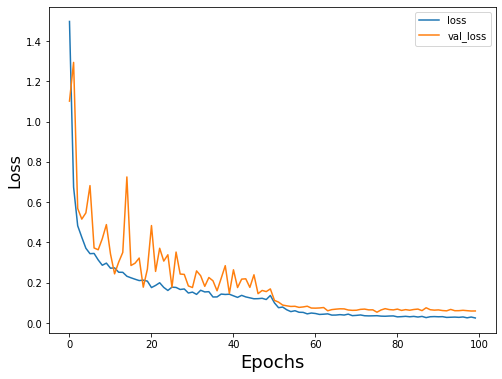

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

hist_csv = "/mntDrive/My Drive/TrainingHistory/vmmr_net_4/vmmr_net_history.csv"
hist = pd.read_csv(hist_csv)

hist.plot(kind="line", y=["loss", "val_loss"], figsize=(8, 6))
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=16)
plt.show()

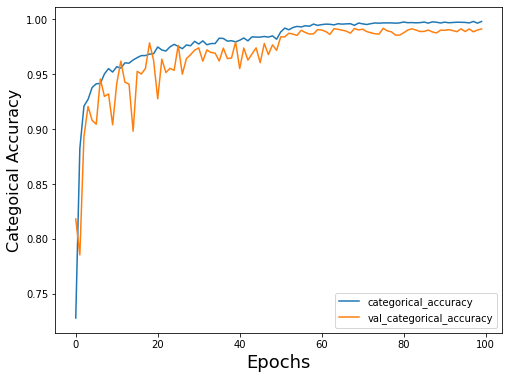

In [ ]:
hist.plot(kind="line", y=["categorical_accuracy", "val_categorical_accuracy"], figsize=(8, 6))
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Categoical Accuracy', fontsize=16)
plt.show()

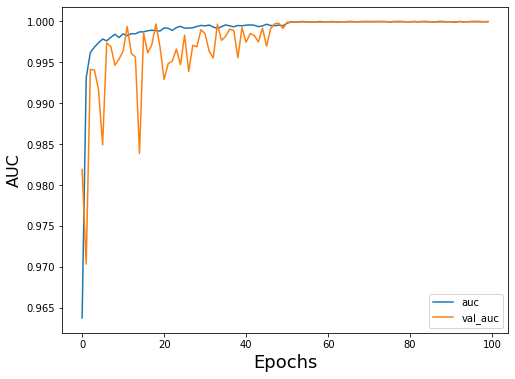

In [ ]:
hist.plot(kind="line", y=["auc", "val_auc"], figsize=(8, 6))
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('AUC', fontsize=16)
plt.show()

In [ ]:
vmmr_model = load_model("/mntDrive/My Drive/Models/vmmr_net_3.h5")

In [ ]:
import cv2
import numpy as np
from keras.utils import to_categorical

sanity_path = "/mntDrive/My Drive/Dataset/car_dataset_test/"

results = {}

indices = {'audi a3': 0, 'audi a4': 1, 'audi q7': 2, 'bmw 1 series': 3, 'nissan micra': 4, 'opel astra': 5, 'renault captur': 6, 
           'renault clio': 7, 'renault megane': 8, 'volkswagen golf': 9, 'volkswagen passat': 10, 'volkswagen polo': 11}

inv_indices = {v: k for k, v in indices.items()}

y_pred, y = [], []

for folder in os.listdir(sanity_path):
  img_path = os.path.join(sanity_path, folder)
  for img in os.listdir(img_path):
    p = os.path.join(img_path, img)

    img_data = cv2.imread(p)
    img_data = img_data.astype(np.float32)
    img_data = cv2.resize(img_data, (224, 224))
    img_data = np.expand_dims(img_data, axis=0)

    pred = vmmr_model.predict(img_data)

    y_pred.append(pred[0])
    y.append(to_categorical(indices[folder], num_classes=12))    

y_pred = np.asarray(y_pred)
y = np.asarray(y)

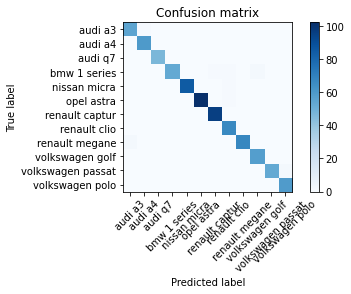

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, names, title='Confusion matrix', 
                            cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y, y_pred)

plot_confusion_matrix(cm, names=indices.keys())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


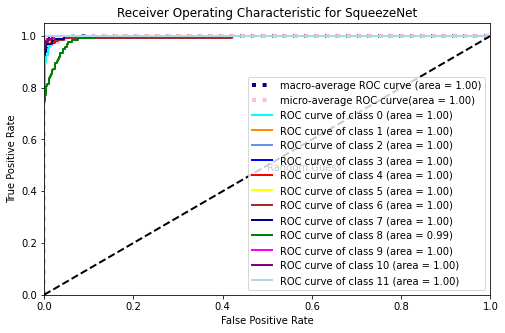

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 12

fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw=2
plt.figure(figsize=(8,5))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve(area = {0:0.2f})'.format(roc_auc["micro"]), color="pink", linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', "blue", "red", "yellow", "brown", "darkblue", "green", "magenta", "purple", "lightblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='black', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for SqueezeNet')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import os
from random import shuffle

data_path = "/mntDrive/My Drive/Dataset/car_dataset_extracted"
val_path = "/mntDrive/My Drive/Dataset/car_dataset_test"

# all_imgs = []
# for folder in os.listdir(data_path):
#   folder_path = os.path.join(data_path, folder)
#   for f in os.listdir(folder_path):
#     if f.endswith(".jpg") or f.endswith(".png") or f.endswith(".jpeg"):
#       all_imgs.append(os.path.join(folder_path, f))

# len(all_imgs)
# for item in all_imgs:
#   print(item)

# shuffle(all_imgs)
# for i in all_imgs:
#   print(i)
i = 0
for folder in os.listdir(data_path):
  training_observation_path = os.path.join(data_path, folder)
  val_observation_path = os.path.join(val_path, folder)
  val_imgs = os.listdir(val_observation_path)
  for img in os.listdir(training_observation_path):
    if img in val_imgs:
      i += 1
      print(f"{training_observation_path}/{img} is in validation data")

print(i)
      


0
